In [1]:
import matplotlib
from IPython.display import display
#matplotlib.use('agg') 

import torch
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ExponentialLR

import numpy as np
from scipy.stats import entropy
from tqdm import tqdm

from utils.ACTS_helper import *
from utils.custom_classical_models import *
from utils.custom_functions import *

import os
import time
import argparse
import glob
import re

import matplotlib.pyplot as plt

import optuna

In [2]:
def get_args():
    parser = argparse.ArgumentParser(description='training quGAN for FCS')
    
    parser.add_argument('--n_epochs', type=int, default=200, dest='n_epochs', help='number of epochs to run')
    parser.add_argument('--run_dir', type=str, default='C:\\work_local\\TBGan\\runs', dest='run_dir', help='dir to save the models')
    parser.add_argument('--data_dir', type=str, default='C:\\work_local\\TBGan\\data', dest='data_dir', help='dir to the input data')

    parser.add_argument('-s', '--seed', type=int, default=0, dest='seed', help='seed of the random generator')
    parser.add_argument('-l', '--layer', type=int, default=None, dest='layer', help='select one layer data')
    parser.add_argument('--sample_size', type=int, default=10000, dest='sample_size', help='size of the sample')

    parser.add_argument('--batch_size', type=int, default=512, dest='batch_size', help='size of the batch')
    parser.add_argument('--loss_function', type=str, choices=['cross_entropy', 'wasserstein_distance'], default='wasserstein_distance', dest='loss_function', help='loss function')
    parser.add_argument('--disc_gen_ratio', type=int, default=10, dest='disc_gen_ratio')
    parser.add_argument('--lr_gen', type=float, default=0.008, dest='lr_gen', help='generator learning rate')
    parser.add_argument('--lr_disc', type=float, default=0.001, dest='lr_disc', help='discriminator learning rate')
    parser.add_argument('--gamma', type=float, default=0.95, dest='gamma', help='decay factor of the learning rate')
    parser.add_argument('--lambda_gp', type=int, default=10, dest='lambda_gp', help='gradient penalty factor')    

    parser.add_argument('--model_name', type=str, choices=['DensityNN', 'BinaryNeuron', 'CNN'], default='DensityNN', dest='model_name', help='model_name')
    
    args = parser.parse_args([
        '--n_epochs', '200', 
        '--sample_size', '10000',
        '--batch_size', '100', 
        '--gamma', '0.995',
        '--loss_function', 'wasserstein_distance',
        '--model_name', 'CNN'
    ])
 
    return args

In [3]:
# Parameters
args = get_args()
print(args)

seed = args.seed
sample_size = args.sample_size

n_epochs = args.n_epochs
batch_size = args.batch_size
loss_function = args.loss_function
disc_gen_ratio = args.disc_gen_ratio
lr_gen = args.lr_gen
gen_gamma = args.gamma
lr_disc = args.lr_disc
disc_gamma = args.gamma
lambda_gp = args.lambda_gp

run_dir = args.run_dir
data_dir = args.data_dir

model_name = args.model_name

cuda = True if torch.cuda.is_available() else False

print(cuda)
if loss_function == 'cross_entropy':
    parameter_config = f'batch{batch_size}_gamma{args.gamma}_ce'
elif loss_function == 'wasserstein_distance':
    parameter_config = f'batch{batch_size}_gamma{args.gamma}_wd'

# experiment = f'{parameter_config}/s{seed}'

Namespace(n_epochs=200, run_dir='C:\\work_local\\TBGan\\runs', data_dir='C:\\work_local\\TBGan\\data', seed=0, layer=None, sample_size=10000, batch_size=100, loss_function='wasserstein_distance', disc_gen_ratio=10, lr_gen=0.008, lr_disc=0.001, gamma=0.995, lambda_gp=10, model_name='CNN')
True


Processing C:\work_local\TBGan\data\cluster_epoch0.npy
Processing C:\work_local\TBGan\data\cluster_epoch1.npy
Initializing ACTS 1D dataset ...
Shape of the dataset is:  (10000, 8, 8, 11)
length of the training set: 10000
length of the validation set: 0


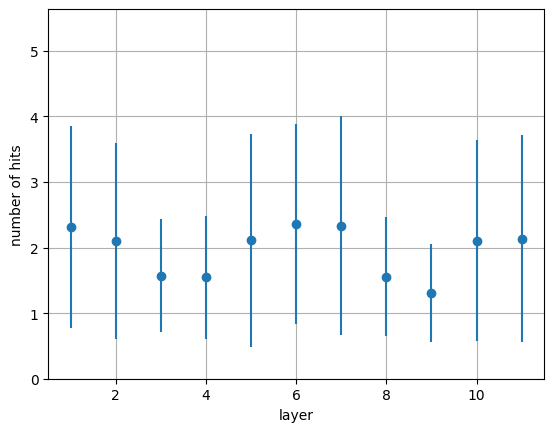

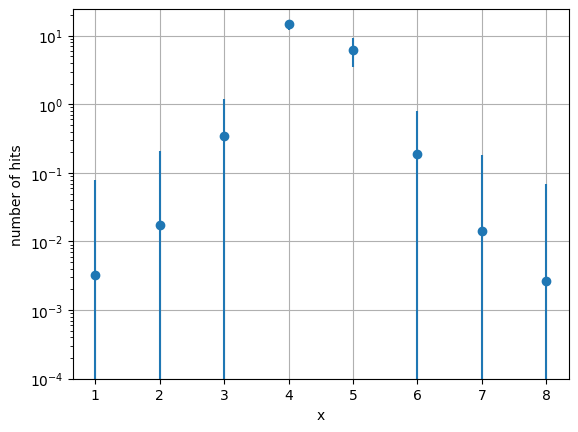

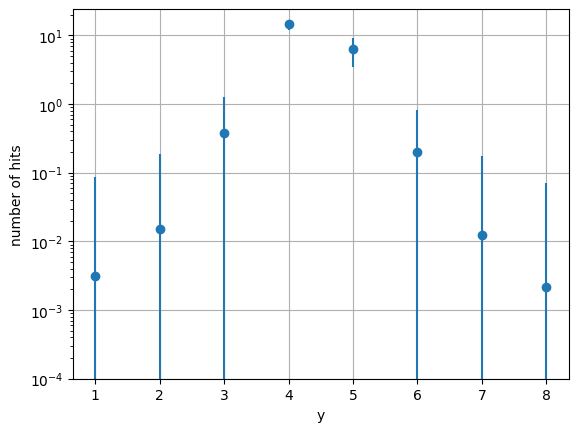

In [4]:
# Load the dataset
input_fn = f'{data_dir}/*.npy'
ACTS_dataset = ACTS(input_fn, sample_size=sample_size, min_fraction = 0.001)

train_dataset, validation_dataset = random_split(ACTS_dataset, [sample_size, 0], torch.Generator().manual_seed(42))
data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
print(f'length of the training set: {len(train_dataset)}')
print(f'length of the validation set: {len(validation_dataset)}')

show_mean_std(ACTS_dataset.pixel_hit, axis=(1,2), xlabel='layer')
show_mean_std(ACTS_dataset.pixel_hit, axis=(2,3), xlabel='x', log=True)
show_mean_std(ACTS_dataset.pixel_hit, axis=(1,3), xlabel='y', log=True)

real_prob, _ = cal_mean_std(ACTS_dataset.pixel_hit)
real_prob = real_prob.reshape(-1) + 1e-8

# Set the random seed for reproducibility
torch.manual_seed(seed)
np.random.seed(seed)
import random
random.seed(seed)

In [5]:
def objective(trial):
    gen = Optuna_Gen(input_size=50,
                     hidden_layers_size=[trial.suggest_int('g_layer1', 8, 128), trial.suggest_int('g_layer2', 8, 128), trial.suggest_int('g_layer3', 8, 128)],
                     batch_norm=trial.suggest_int('g_bn', 0, 1))
    
    disc = Optuna_Disc(input_size=100,
                       hidden_layers_size=[trial.suggest_int('d_layer1', 8, 128), trial.suggest_int('d_layer2', 8, 128), trial.suggest_int('d_layer3', 8, 128)],
                       batch_norm=trial.suggest_int('d_bn', 0, 1))

    gen_optim = torch.optim.Adam(gen.parameters(), lr=lr_gen, betas = (0.9, 0.999))
    gen_scheduler = ExponentialLR(gen_optim, gamma = gen_gamma)

    disc_optim = torch.optim.Adam(disc.parameters(), lr=lr_disc, betas = (0.9, 0.999))
    disc_scheduler = ExponentialLR(disc_optim, gamma = disc_gamma)

    if cuda:
        gen.cuda()
        disc.cuda()

    gen.train()
    disc.train()

    for epoch in range(n_epochs):
        disc_loss_epoch = []
        disc_real_loss_epoch = []
        disc_fake_loss_epoch = []
        disc_gradient_penalty_epoch = []
        gen_loss_epoch = []
        relative_entropy_epoch = []
        disc_iterations = 0
        
        bar_format="{l_bar}{bar:5}|{n_fmt}/{total_fmt} [{elapsed}<{remaining}{postfix}]"
        loop = tqdm(data_loader, leave = False, disable = False, bar_format = bar_format, ncols = 100)
        for real_data in loop:
            if cuda:
                real_data = real_data.view(batch_size, -1).cuda()
            else:
                real_data = real_data.view(batch_size, -1)
            # Step 1: train the discriminator
            fake_data = generate_fake_data(gen, batch_size).detach()
            if loss_function == 'cross_entropy':
                disc_loss, disc_real_loss, disc_fake_loss = cal_disc_ce_loss(disc, real_data, fake_data)
            elif loss_function == 'wasserstein_distance':
                disc_loss, disc_real_loss, disc_fake_loss, disc_gradient_penalty = cal_disc_W_loss(disc, real_data, fake_data, lambda_gp)
            else:
                raise Exception(f'{loss_function} not supported')
            
            # update the parameter
            disc_optim.zero_grad()
            disc_loss.backward()
            disc_optim.step()
    
            disc_iterations += 1
            disc_loss_epoch.append(disc_loss.item())
            disc_real_loss_epoch.append(disc_real_loss.item())
            disc_fake_loss_epoch.append(disc_fake_loss.item())
            disc_gradient_penalty_epoch.append(disc_gradient_penalty.item())
            
            # Step 2: train the generator
            if disc_iterations % disc_gen_ratio == 0:
                fake_data = generate_fake_data(gen, batch_size)
                if loss_function == 'cross_entropy':
                    gen_loss = cal_gen_ce_loss(disc, fake_data)
                elif loss_function == 'wasserstein_distance':
                    gen_loss = cal_gen_W_loss(disc, fake_data)
                else:
                    raise Exception(f'{loss_function} not supported')
    
                # update the parameter
                gen_optim.zero_grad()
                gen_loss.backward()
                gen_optim.step()
    
                gen_loss_epoch.append(gen_loss.item())
                
                loop.set_description(f"Epoch [{epoch}/{n_epochs}]")
                loop.set_postfix({'gen_loss' : gen_loss.item(), 'dis_loss' : disc_loss.item()})
    
    gen_prob = np.mean(generate_validation_data(gen, sample_size).detach().cpu().numpy(), axis = 0)
    gen_prob = [1e-8 if x == 0 else x for x in gen_prob]
    accuracy = sum((real_prob - gen_prob)**2)
    print(accuracy)

    return accuracy

study = optuna.create_study(study_name = "TBGan", direction='minimize', storage="sqlite:///db.sqlite3")
study.optimize(objective, n_trials=25)

[I 2023-09-12 16:44:30,231] A new study created in RDB with name: TBGan
[I 2023-09-12 16:46:06,146] Trial 0 finished with value: 0.18726166716291856 and parameters: {'g_layer1': 66, 'g_layer2': 120, 'g_layer3': 19, 'g_bn': 0, 'd_layer1': 117, 'd_layer2': 38, 'd_layer3': 69, 'd_bn': 0}. Best is trial 0 with value: 0.18726166716291856.


0.18726166716291856


[I 2023-09-12 16:48:30,785] Trial 1 finished with value: 11730081666.159664 and parameters: {'g_layer1': 40, 'g_layer2': 86, 'g_layer3': 27, 'g_bn': 0, 'd_layer1': 44, 'd_layer2': 113, 'd_layer3': 65, 'd_bn': 1}. Best is trial 0 with value: 0.18726166716291856.


11730081666.159664


[I 2023-09-12 16:50:00,872] Trial 2 finished with value: 0.12242653729559458 and parameters: {'g_layer1': 15, 'g_layer2': 17, 'g_layer3': 98, 'g_bn': 0, 'd_layer1': 56, 'd_layer2': 37, 'd_layer3': 70, 'd_bn': 0}. Best is trial 2 with value: 0.12242653729559458.


0.12242653729559458


[I 2023-09-12 16:52:27,958] Trial 3 finished with value: 761452297864.2365 and parameters: {'g_layer1': 99, 'g_layer2': 50, 'g_layer3': 121, 'g_bn': 0, 'd_layer1': 70, 'd_layer2': 80, 'd_layer3': 37, 'd_bn': 1}. Best is trial 2 with value: 0.12242653729559458.


761452297864.2365


[I 2023-09-12 16:54:53,028] Trial 4 finished with value: 8241765914.1791725 and parameters: {'g_layer1': 15, 'g_layer2': 22, 'g_layer3': 94, 'g_bn': 0, 'd_layer1': 19, 'd_layer2': 120, 'd_layer3': 117, 'd_bn': 1}. Best is trial 2 with value: 0.12242653729559458.


8241765914.1791725


[I 2023-09-12 16:56:31,026] Trial 5 finished with value: 0.06485819688626698 and parameters: {'g_layer1': 53, 'g_layer2': 70, 'g_layer3': 85, 'g_bn': 1, 'd_layer1': 121, 'd_layer2': 73, 'd_layer3': 21, 'd_bn': 0}. Best is trial 5 with value: 0.06485819688626698.


0.06485819688626698


[I 2023-09-12 16:58:57,627] Trial 6 finished with value: 3651084007326.3945 and parameters: {'g_layer1': 126, 'g_layer2': 68, 'g_layer3': 110, 'g_bn': 0, 'd_layer1': 13, 'd_layer2': 69, 'd_layer3': 18, 'd_bn': 1}. Best is trial 5 with value: 0.06485819688626698.


3651084007326.3945


[I 2023-09-12 17:00:33,116] Trial 7 finished with value: 0.21711514740035054 and parameters: {'g_layer1': 40, 'g_layer2': 61, 'g_layer3': 94, 'g_bn': 0, 'd_layer1': 122, 'd_layer2': 65, 'd_layer3': 17, 'd_bn': 0}. Best is trial 5 with value: 0.06485819688626698.


0.21711514740035054


[I 2023-09-12 17:03:02,367] Trial 8 finished with value: 20069092991.680786 and parameters: {'g_layer1': 64, 'g_layer2': 37, 'g_layer3': 35, 'g_bn': 0, 'd_layer1': 78, 'd_layer2': 23, 'd_layer3': 126, 'd_bn': 1}. Best is trial 5 with value: 0.06485819688626698.


20069092991.680786


[I 2023-09-12 17:04:38,756] Trial 9 finished with value: 0.12244494399675336 and parameters: {'g_layer1': 33, 'g_layer2': 87, 'g_layer3': 106, 'g_bn': 1, 'd_layer1': 26, 'd_layer2': 93, 'd_layer3': 72, 'd_bn': 0}. Best is trial 5 with value: 0.06485819688626698.


0.12244494399675336


[I 2023-09-12 17:06:14,316] Trial 10 finished with value: 0.06394993327795234 and parameters: {'g_layer1': 88, 'g_layer2': 122, 'g_layer3': 61, 'g_bn': 1, 'd_layer1': 93, 'd_layer2': 53, 'd_layer3': 40, 'd_bn': 0}. Best is trial 10 with value: 0.06394993327795234.


0.06394993327795234


[I 2023-09-12 17:07:52,368] Trial 11 finished with value: 0.09421794934907164 and parameters: {'g_layer1': 91, 'g_layer2': 128, 'g_layer3': 62, 'g_bn': 1, 'd_layer1': 96, 'd_layer2': 53, 'd_layer3': 41, 'd_bn': 0}. Best is trial 10 with value: 0.06394993327795234.


0.09421794934907164


[I 2023-09-12 17:09:33,985] Trial 12 finished with value: 0.08920414038566747 and parameters: {'g_layer1': 81, 'g_layer2': 99, 'g_layer3': 62, 'g_bn': 1, 'd_layer1': 98, 'd_layer2': 97, 'd_layer3': 41, 'd_bn': 0}. Best is trial 10 with value: 0.06394993327795234.


0.08920414038566747


[I 2023-09-12 17:11:09,198] Trial 13 finished with value: 0.08924627132573121 and parameters: {'g_layer1': 113, 'g_layer2': 108, 'g_layer3': 75, 'g_bn': 1, 'd_layer1': 100, 'd_layer2': 10, 'd_layer3': 12, 'd_bn': 0}. Best is trial 10 with value: 0.06394993327795234.


0.08924627132573121


[I 2023-09-12 17:12:48,987] Trial 14 finished with value: 0.05634544655088651 and parameters: {'g_layer1': 58, 'g_layer2': 83, 'g_layer3': 51, 'g_bn': 1, 'd_layer1': 127, 'd_layer2': 53, 'd_layer3': 32, 'd_bn': 0}. Best is trial 14 with value: 0.05634544655088651.


0.05634544655088651


[I 2023-09-12 17:14:25,945] Trial 15 finished with value: 0.05854102455062249 and parameters: {'g_layer1': 81, 'g_layer2': 107, 'g_layer3': 43, 'g_bn': 1, 'd_layer1': 88, 'd_layer2': 52, 'd_layer3': 51, 'd_bn': 0}. Best is trial 14 with value: 0.05634544655088651.


0.05854102455062249


[I 2023-09-12 17:16:09,377] Trial 16 finished with value: 0.09161547269778633 and parameters: {'g_layer1': 72, 'g_layer2': 88, 'g_layer3': 49, 'g_bn': 1, 'd_layer1': 80, 'd_layer2': 50, 'd_layer3': 91, 'd_bn': 0}. Best is trial 14 with value: 0.05634544655088651.


0.09161547269778633


[I 2023-09-12 17:17:49,364] Trial 17 finished with value: 0.06547301225679025 and parameters: {'g_layer1': 53, 'g_layer2': 104, 'g_layer3': 43, 'g_bn': 1, 'd_layer1': 114, 'd_layer2': 35, 'd_layer3': 55, 'd_bn': 0}. Best is trial 14 with value: 0.05634544655088651.


0.06547301225679025


[I 2023-09-12 17:19:31,900] Trial 18 finished with value: 0.04974550252108435 and parameters: {'g_layer1': 106, 'g_layer2': 78, 'g_layer3': 14, 'g_bn': 1, 'd_layer1': 51, 'd_layer2': 86, 'd_layer3': 93, 'd_bn': 0}. Best is trial 18 with value: 0.04974550252108435.


0.04974550252108435


[I 2023-09-12 17:21:09,547] Trial 19 finished with value: 0.0568219306431967 and parameters: {'g_layer1': 118, 'g_layer2': 76, 'g_layer3': 19, 'g_bn': 1, 'd_layer1': 40, 'd_layer2': 88, 'd_layer3': 94, 'd_bn': 0}. Best is trial 18 with value: 0.04974550252108435.


0.0568219306431967


[I 2023-09-12 17:23:45,208] Trial 20 finished with value: 5798.8727466163255 and parameters: {'g_layer1': 101, 'g_layer2': 53, 'g_layer3': 31, 'g_bn': 1, 'd_layer1': 58, 'd_layer2': 104, 'd_layer3': 91, 'd_bn': 1}. Best is trial 18 with value: 0.04974550252108435.


5798.8727466163255


[I 2023-09-12 17:25:27,615] Trial 21 finished with value: 0.06301929032415196 and parameters: {'g_layer1': 127, 'g_layer2': 76, 'g_layer3': 8, 'g_bn': 1, 'd_layer1': 41, 'd_layer2': 85, 'd_layer3': 98, 'd_bn': 0}. Best is trial 18 with value: 0.04974550252108435.


0.06301929032415196


[I 2023-09-12 17:27:07,970] Trial 22 finished with value: 0.0574446375754164 and parameters: {'g_layer1': 110, 'g_layer2': 78, 'g_layer3': 9, 'g_bn': 1, 'd_layer1': 36, 'd_layer2': 128, 'd_layer3': 103, 'd_bn': 0}. Best is trial 18 with value: 0.04974550252108435.


0.0574446375754164


[I 2023-09-12 17:28:50,134] Trial 23 finished with value: 0.06643217582844041 and parameters: {'g_layer1': 112, 'g_layer2': 92, 'g_layer3': 20, 'g_bn': 1, 'd_layer1': 59, 'd_layer2': 87, 'd_layer3': 87, 'd_bn': 0}. Best is trial 18 with value: 0.04974550252108435.


0.06643217582844041


[I 2023-09-12 17:30:34,688] Trial 24 finished with value: 0.23926397764600915 and parameters: {'g_layer1': 118, 'g_layer2': 56, 'g_layer3': 16, 'g_bn': 1, 'd_layer1': 30, 'd_layer2': 77, 'd_layer3': 109, 'd_bn': 0}. Best is trial 18 with value: 0.04974550252108435.


0.23926397764600915
